In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from random import seed,sample
import datetime as dt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler # Undersampling for Unbalanced Data
from imblearn.over_sampling import SMOTE # Oversampling for Unbalanced Data
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler # Data Encoders
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
import networkx as nx

In [2]:
df = pd.read_csv("C:/Users/sieji/OneDrive/Documents/NUS/BT4012/bt4012/fraudTrain.csv")
df = pd.concat([df[df["is_fraud"]==0].sample(frac=0.20, random_state=42), df[df["is_fraud"] == 1]])

In [3]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
811778,811778,2019-12-07 10:55:06,676173792455,"fraud_Zieme, Bode and Dooley",gas_transport,86.19,Brittany,Cox,F,07177 William Dale Apt. 547,...,34.0287,-118.4924,92043,"Civil engineer, contracting",1961-04-25,f32d1f4b2a918f4c2f6acdc83033ee35,1354877706,33.287851,-118.740970,0
1101718,1101718,2020-04-03 13:10:06,30518206766474,fraud_Lind-Buckridge,entertainment,85.81,Tamara,Martinez,F,471 Marquez Prairie Suite 680,...,36.7154,-89.6287,1019,Aeronautical engineer,1979-01-26,f5dad8e2d7c39d81502d846a20286659,1364994606,36.539950,-89.857416,0
800013,800013,2019-12-04 07:07:04,4658490815480264,fraud_Hackett-Lueilwitz,grocery_pos,99.30,Tara,Richards,F,4879 Cristina Station,...,39.9636,-79.7853,184,Systems developer,1945-11-04,1d023bc78ab93ab65a35bbb53bcc67bd,1354604824,39.582872,-78.838550,0
398945,398945,2019-06-30 18:43:08,4716561796955522,fraud_Lynch-Wisozk,home,42.09,Lauren,Anderson,F,11014 Chad Lake Apt. 573,...,48.2777,-112.8456,743,Water engineer,1972-05-04,dbf6c06d3277438afdf7af883fb4285f,1341081788,48.310513,-112.837535,0
207455,207455,2019-04-15 19:57:49,3528407217576457,fraud_Fisher-Schowalter,shopping_net,4.24,Patricia,Leach,F,71309 Martinez Stravenue,...,36.4715,-82.4834,87124,Warden/ranger,1987-02-14,88814660aba0101b174e1e8137f4a7af,1334519869,37.329094,-82.070746,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265340 entries, 811778 to 1295733
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             265340 non-null  int64  
 1   trans_date_trans_time  265340 non-null  object 
 2   cc_num                 265340 non-null  int64  
 3   merchant               265340 non-null  object 
 4   category               265340 non-null  object 
 5   amt                    265340 non-null  float64
 6   first                  265340 non-null  object 
 7   last                   265340 non-null  object 
 8   gender                 265340 non-null  object 
 9   street                 265340 non-null  object 
 10  city                   265340 non-null  object 
 11  state                  265340 non-null  object 
 12  zip                    265340 non-null  int64  
 13  lat                    265340 non-null  float64
 14  long                   265340 non-n

In [5]:
# Calculate the total number of rows in the DataFrame
total_rows = len(df)

# Calculate the number of fraud (is_fraud=1) and non-fraud (is_fraud=0) rows
fraud_count = df[df["is_fraud"] == 1]["is_fraud"].count()
non_fraud_count = df[df["is_fraud"] == 0]["is_fraud"].count()

# Calculate the proportions
fraud_proportion = fraud_count / total_rows
non_fraud_proportion = non_fraud_count / total_rows

# Print the proportions
print("Proportion of Fraudulent Transactions:", fraud_proportion)
print("Proportion of Non-Fraudulent Transactions:", non_fraud_proportion)


Proportion of Fraudulent Transactions: 0.028288233963970753
Proportion of Non-Fraudulent Transactions: 0.9717117660360293


In [7]:

#Dual classification graph creation function
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    
    # Create graph nodes by mapping unique credit card numbers and merchant IDs
    mapping = {x:node_id for node_id,x in enumerate(set(df["cc_num"].values.tolist() + df["merchant"].values.tolist()))}
    df["from"] = df["cc_num"].apply(lambda x: mapping[x])
    df["to"] = df["merchant"].apply(lambda x: mapping[x])
    
    #Group by 'from', 'to', 'amt', 'is_fraud' columns and calculate sum
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from', 'to']).agg({"is_fraud": "sum", "amt": "sum"}).reset_index()
    
    #Convert 'is_fraud' column to 0 and 1
    df["is_fraud"] = df["is_fraud"].apply(lambda x: 1 if x>0 else 0)
    
    #Graph creation
    G = nx.from_edgelist(df[["from", "to"]].values, create_using=graph_type)
    
    #Node property settings
    nx.set_node_attributes(G,{x:1 for x in df["from"].unique()}, "bipartite")
    nx.set_node_attributes(G,{x:2 for x in df["to"].unique()}, "bipartite")
    
    #Edge label settings
    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, 
                       "label")

    #Edge weight settings
    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["amt"] for idx, x in df[["from","to","amt"]].iterrows()}, 
                       "weight")
    return G

#Triple classification graph creation function
def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    
    mapping = {x:node_id for node_id,x in enumerate(set(df.index.values.tolist() + 
                                                        df["cc_num"].values.tolist() + 
                                                        df["merchant"].values.tolist()))}
    df["in_node"] = df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"] = df["merchant"].apply(lambda x: mapping[x])

    G = nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +
                         [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], 
                         create_using=graph_type)

    nx.set_node_attributes(G,{x["in_node"]:1 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{x["out_node"]:2 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{mapping[idx]:3 for idx, x in df.iterrows()}, "bipartite")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    return G

Build the Bipartite and Tripartite graphs

In [8]:
G_bu = build_graph_bipartite(df, nx.Graph(name = 'Bipartite Undirected'))
G_bd = build_graph_bipartite(df, nx.DiGraph(name = 'Bipartite Directed'))
G_tu = build_graph_tripartite(df, nx.Graph(name = 'Bipartite Undirected'))
G_td = build_graph_tripartite(df, nx.DiGraph(name='Tripartite Directed'))

In [9]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(G_bu)

True

In [10]:

def print_graph_info(graph):
    num_nodes = len(graph.nodes)
    num_edges = len(graph.edges)
    graph_density = num_edges / (num_nodes * (num_nodes - 1) / 2)  # If the graph is undirected
    average_degree = sum(dict(graph.degree()).values()) / num_nodes

    print("Number of nodes:", num_nodes)
    print("Number of edges:", num_edges)
    print("Graph density:", graph_density)
    print("Average degree:", average_degree)
    print("Number of nodes:", num_nodes)

# Example usage:
# Assuming you have created a graph 'G_bu' using your build_graph function
# Replace 'G_bu' with your specific graph
# ...

# Call the function to print information about the graph
print_graph_info(G_bu)


Number of nodes: 1676
Number of edges: 201725
Graph density: 0.1437146012182524
Average degree: 240.7219570405728
Number of nodes: 1676


In [11]:
print_graph_info(G_tu)

Number of nodes: 267016
Number of edges: 530680
Graph density: 1.4886402974790514e-05
Average degree: 3.974892890313689
Number of nodes: 267016


Plotting distribution of node degrees for both graph structures

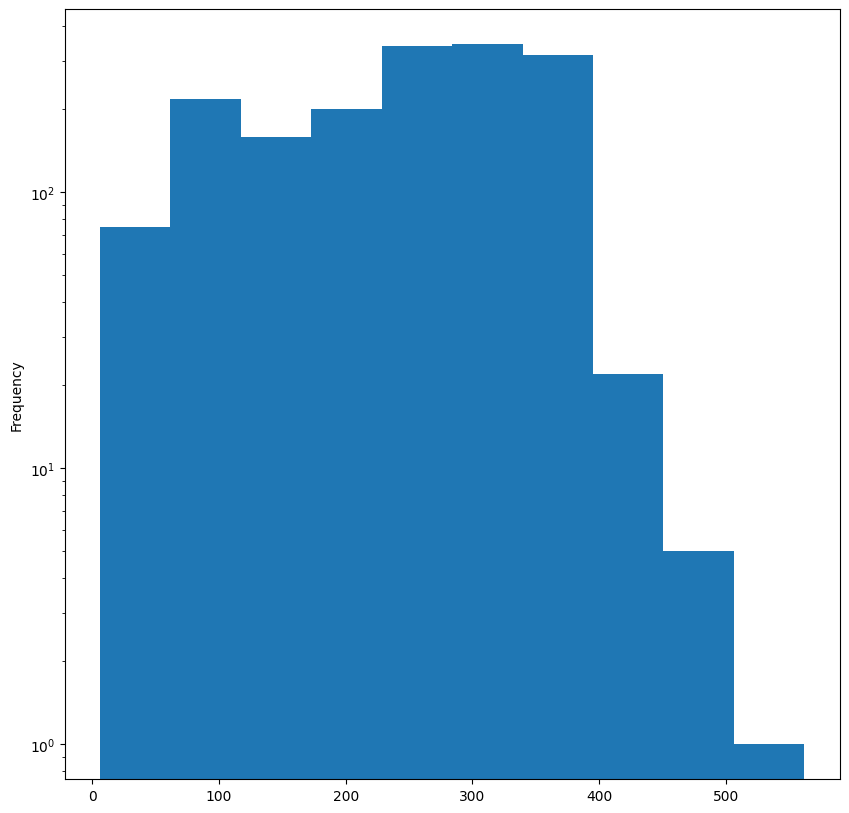

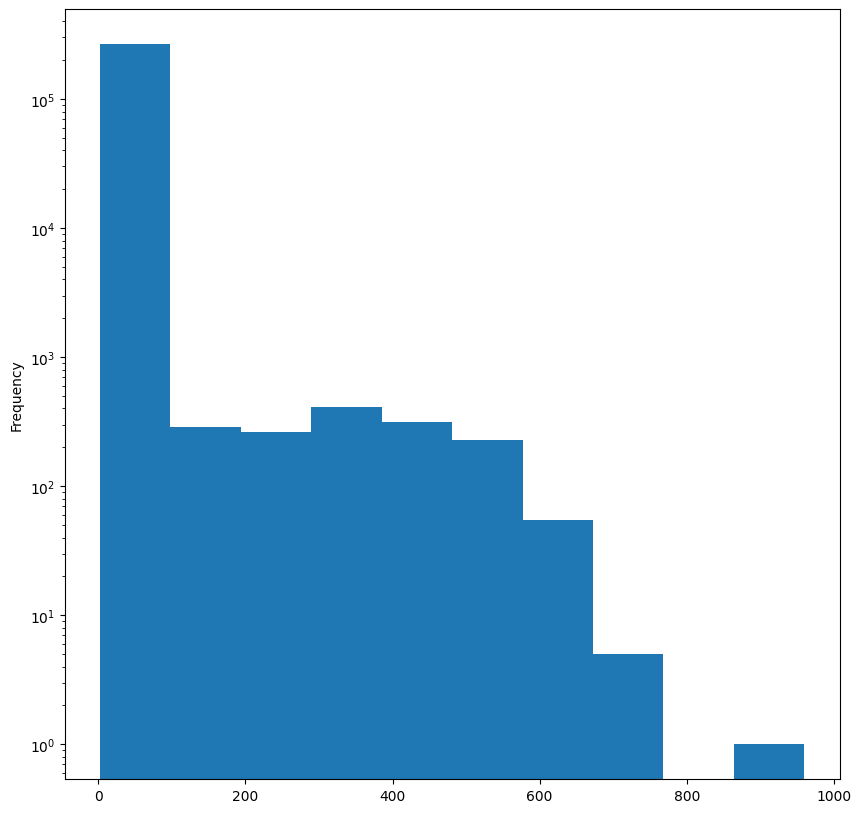

In [12]:
for G in [G_bu, G_tu]:
    plt.figure(figsize=(10,10))
    degrees = pd.Series(
        {
            k:v for k,v in nx.degree(G)
        }
    )
    degrees.plot.hist()
    plt.yscale("log")

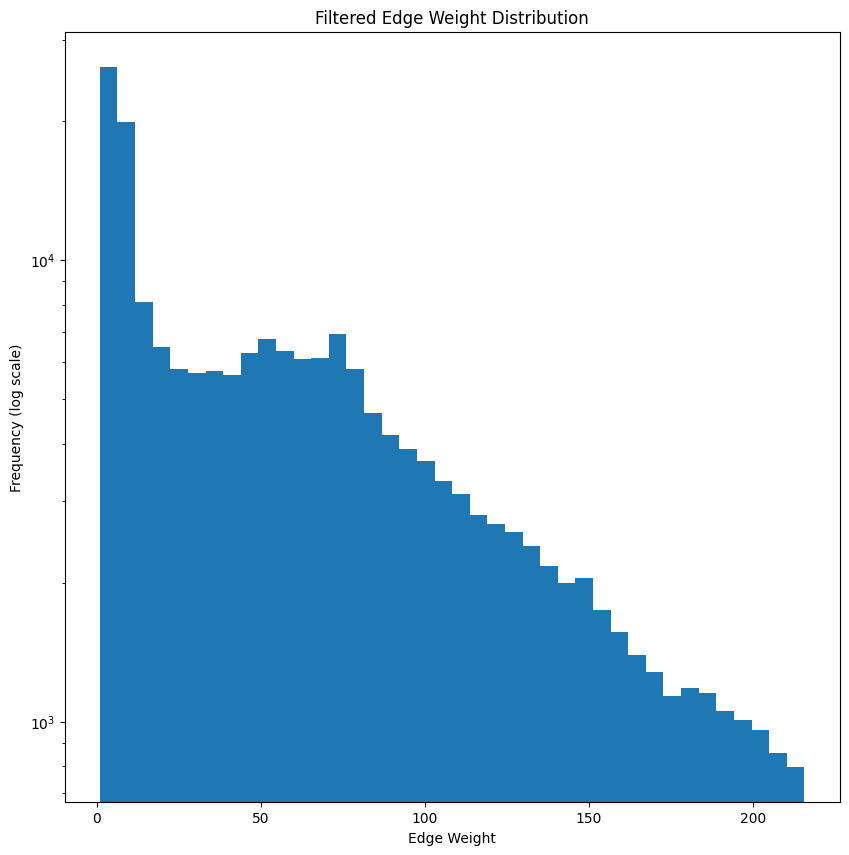

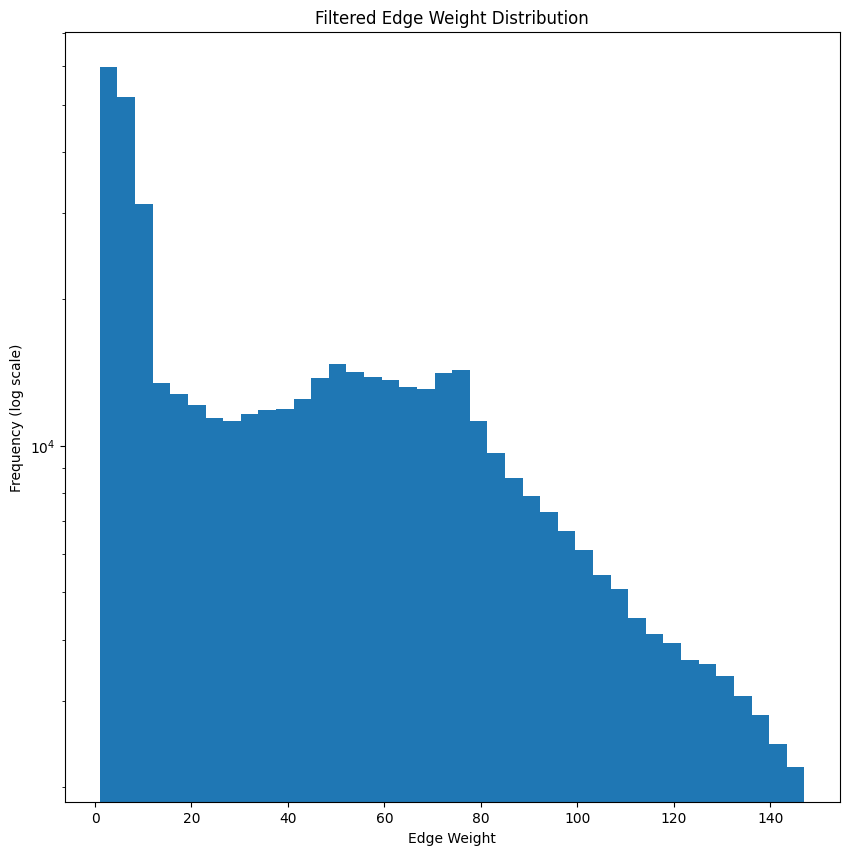

In [13]:
graph_list = [G_bu, G_tu]

# Iterate over each graph
for G in graph_list:
    # Create a pandas Series with edge weights
    all_edge_weights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True)})
    
    # Calculate quantiles for edge weights
    quantiles = np.quantile(all_edge_weights.values, [0.10, 0.50, 0.70, 0.9, 1.0])
    
    # Select a quantile range for filtering
    quant_dist = np.quantile(all_edge_weights.values, [0.10, 0.50, 0.70, 0.9])
    
    # Create a filtered Series with edge weights based on the quantile range
    all_edge_weights_filtered = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True) if d[2]["weight"] < quant_dist[-1]})
    
    # Plot the filtered edge weight distribution using a logarithmic scale
    plt.figure(figsize=(10, 10))
    all_edge_weights_filtered.plot.hist(bins=40)
    plt.yscale("log")
    plt.xlabel('Edge Weight')
    plt.ylabel('Frequency (log scale)')
    plt.title('Filtered Edge Weight Distribution')
    plt.show()


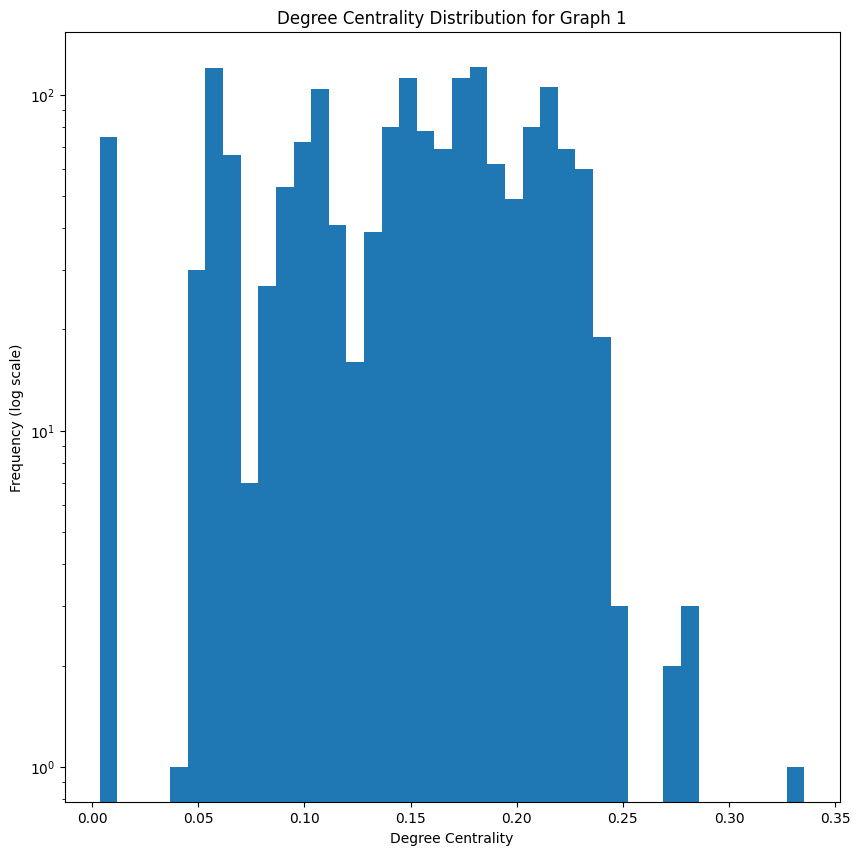

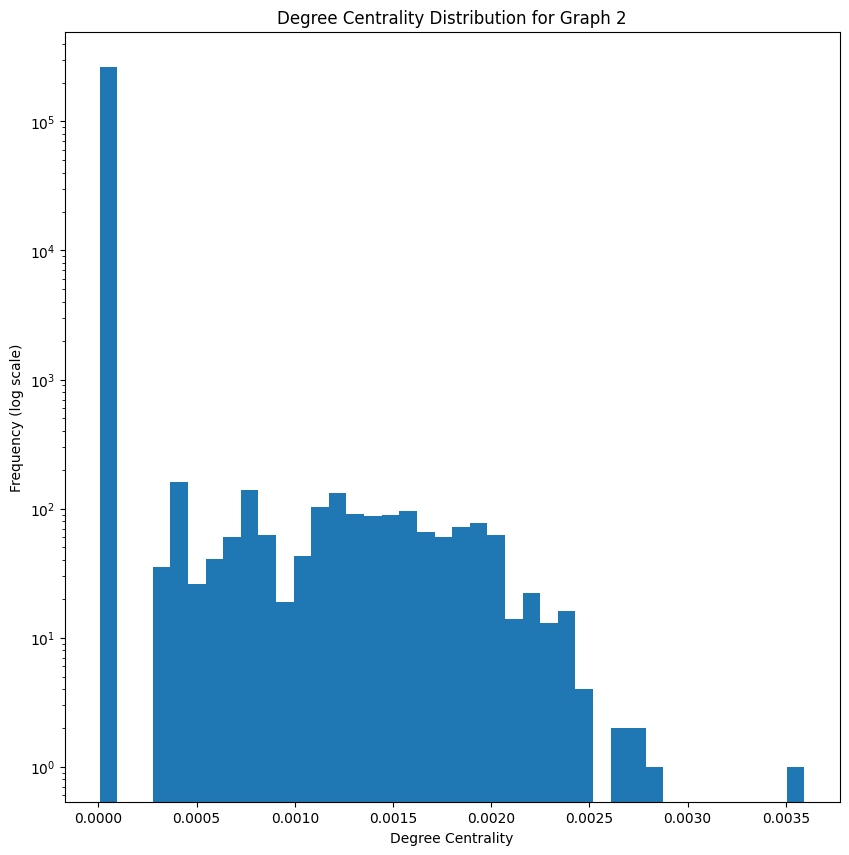

In [14]:
graph_list = [G_bu, G_tu]

# Initialize dictionaries to store degree centrality results for each graph
degree_centrality_results = {}

# Iterate over each graph and plot degree centrality distribution
for i, G in enumerate(graph_list):
    # Calculate degree centrality for the graph
    degree_centrality = nx.degree_centrality(G)
    
    # Convert degree centrality values to a pandas Series
    degree_centrality_series = pd.Series(degree_centrality)
    
    # Plot the degree centrality distribution using a logarithmic scale
    plt.figure(figsize=(10, 10))
    degree_centrality_series.plot.hist(bins=40)
    plt.yscale("log")
    plt.xlabel('Degree Centrality')
    plt.ylabel('Frequency (log scale)')
    plt.title(f'Degree Centrality Distribution for Graph {i + 1}')
    plt.show()

In [15]:
import community
parts = community.best_partition(G_bu, random_state=42, weight='weight')
communities = pd.Series(parts)
communities.value_counts().sort_values(ascending=False)

0     427
2     277
1     262
6     195
5     127
10    113
3      82
7      69
9      50
4      40
8      34
Name: count, dtype: int64

The results indicate that the network can be partitioned into 18 distinct communities. These communities vary in size, with the largest community having 170 nodes and the smallest having 21 nodes. The varying sizes suggest that some groups of nodes are more tightly connected or influential than others within the network

<Axes: ylabel='Frequency'>

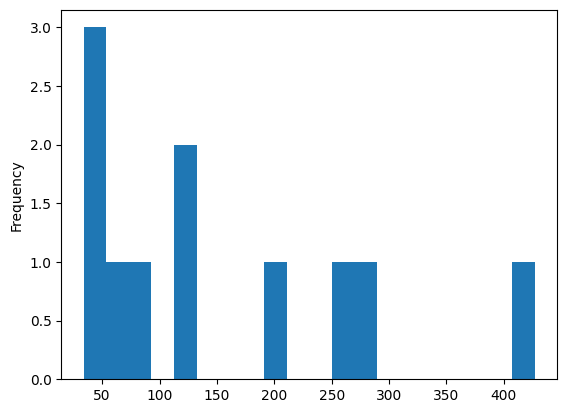

In [17]:
communities.value_counts().plot.hist(bins=20)

In [18]:
community_ratios = {}

for community_id in communities.unique():
    subgraph = nx.subgraph(G_bu, communities[communities == community_id].index)
    total_edges = subgraph.number_of_edges()
    fraud_edges = sum(nx.get_edge_attributes(subgraph, "label").values())

    ratio = 0 if total_edges == 0 else (fraud_edges / total_edges) * 100
    community_ratios[community_id] = ratio
pd.Series(community_ratios).sort_values(ascending=False)


9     21.649485
3     16.184971
7     16.097561
4     15.972222
6     15.547703
10    11.487965
8      8.943089
5      8.132780
1      6.264090
0      3.238210
2      1.218638
dtype: float64

The above is the fraudulent percentage provided at the community level. We can further plot the node-induced subgraphs for a particular community. In the code below, gId indicates the Community ID.

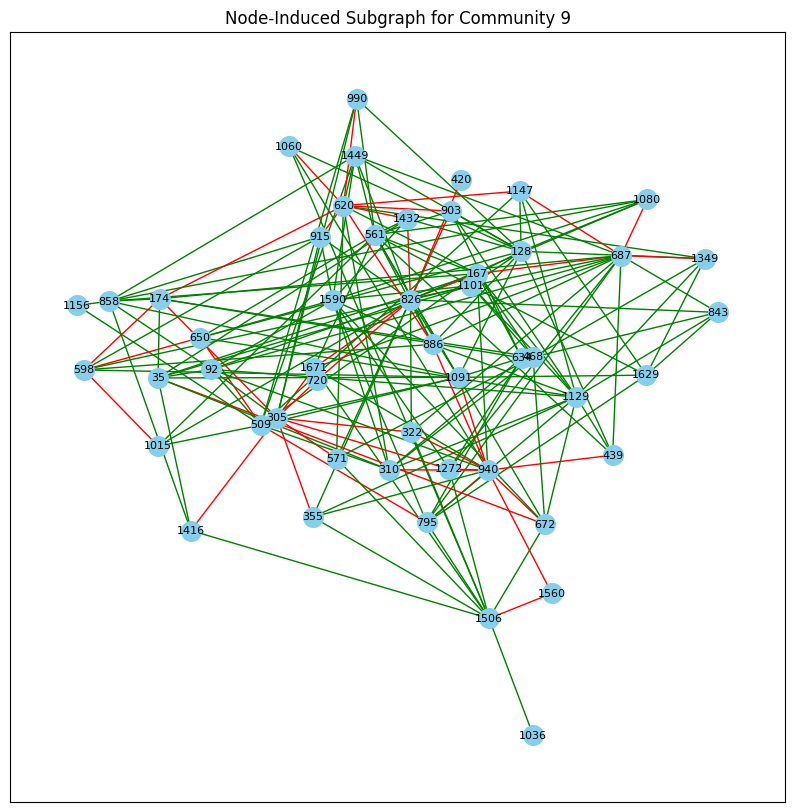

In [19]:
def plot_community_subgraph(graph, community_id):
    # Create a subgraph for the specified community
    subgraph = nx.subgraph(graph, communities[communities == community_id].index)
    
    # Create lists to store edge colors based on their type
    edge_colors = ["green" if subgraph.edges[edge]["label"] == 0 else "red" for edge in subgraph.edges()]

    # Plot the subgraph with edge colors
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(subgraph, seed=42)  # You can use different layout algorithms

    # Draw nodes with labels
    nx.draw_networkx_nodes(subgraph, pos, node_size=200, node_color="skyblue")
    nx.draw_networkx_labels(subgraph, pos, font_size=8)

    # Draw edges with specified colors
    nx.draw_networkx_edges(subgraph, pos, width=1, edge_color=edge_colors)

    plt.title(f"Node-Induced Subgraph for Community {community_id}")
    plt.show()

# Usage: Plot the subgraph for Community 9
plot_community_subgraph(G_bu, community_id=9)

Even though community 9 had the highest percentage of fraud transactions, it seems the volume density is little. Let us plot the community with the second highest percentage.

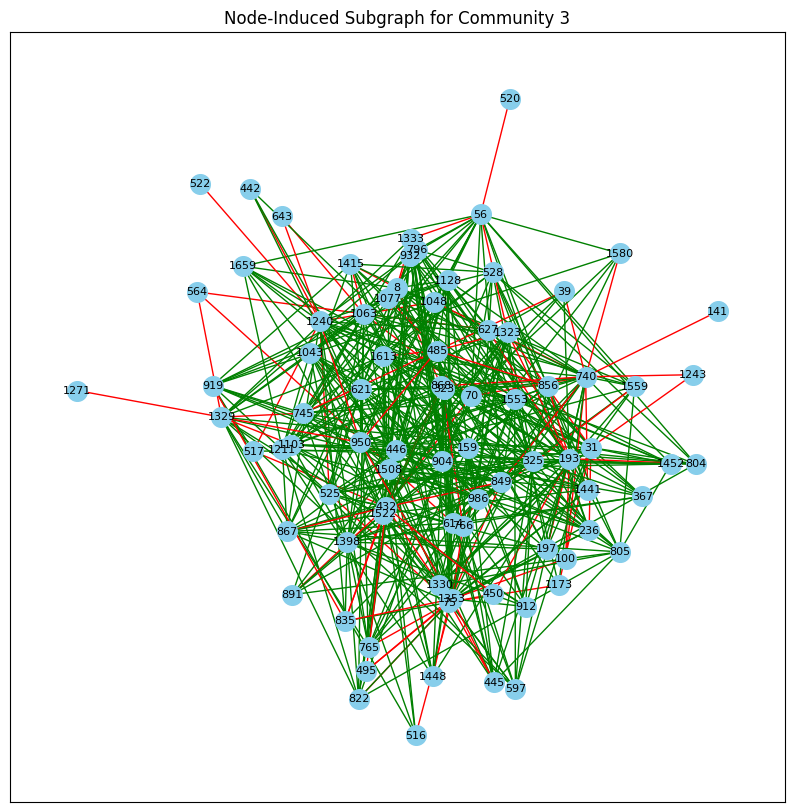

In [20]:
# Usage: Plot the subgraph for Community 3
plot_community_subgraph(G_bu, community_id=3)


Community 3 seems more dense

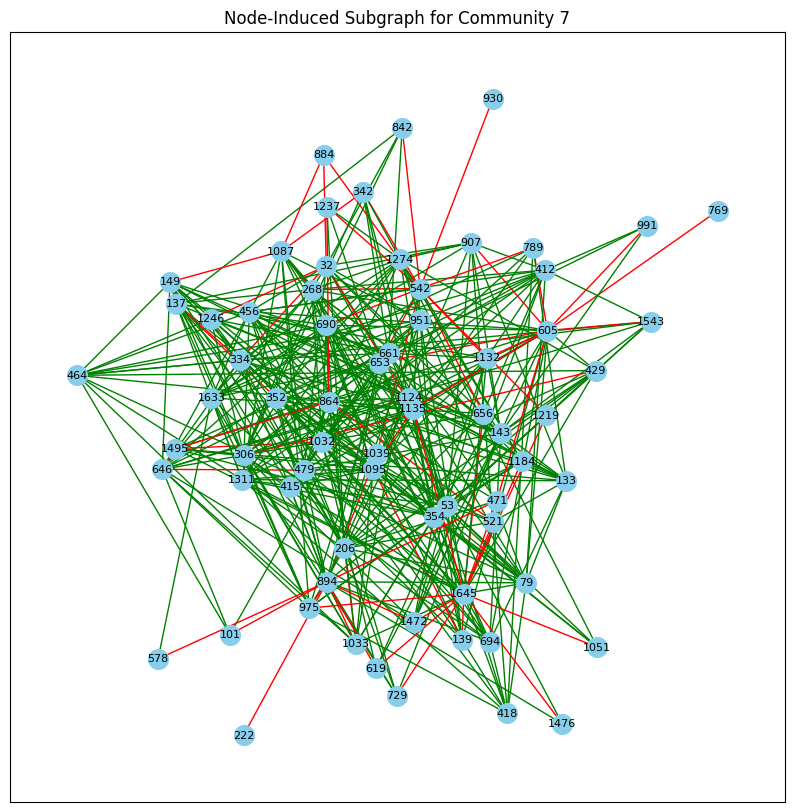

In [21]:
# Usage: Plot the subgraph for Community 7
plot_community_subgraph(G_bu, community_id=7)


Now, we will plot for the community with the least fraud percentage

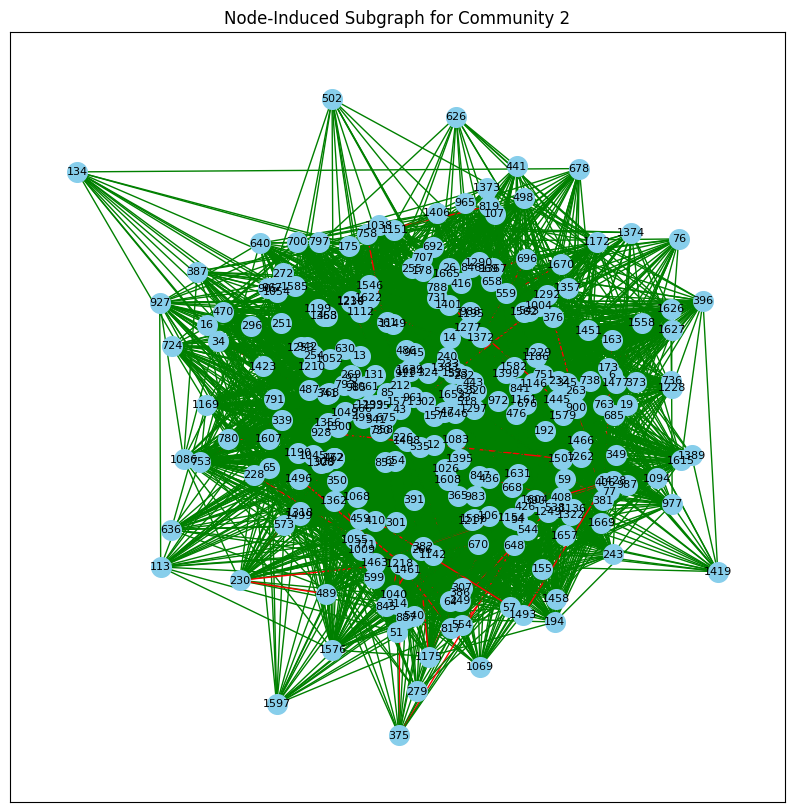

In [22]:
# Usage: Plot the subgraph for Community 2
plot_community_subgraph(G_bu, community_id=2)


Handling Class Imbalance:
In order to build a random forest model, which can be computationally intensive, we will create a downsampled df with equal instances of both fraud and non-fraud classes. This saves time and resources when building the model.

In [85]:
from sklearn.utils import resample

# Split the DataFrame into majority and minority classes
df_majority = df[df.is_fraud == 0]
df_minority = df[df.is_fraud == 1]

# Determine the number of samples to downsample to (e.g., to match the size of the minority class)
num_samples = len(df_minority)

# Downsample the majority class to match the number of samples in the minority class
df_maj_downsampled = resample(df_majority, n_samples=num_samples, random_state=42)

# Concatenate the downsampled majority class with the original minority class
df_downsampled = pd.concat([df_minority, df_maj_downsampled])

# Print the class distribution to verify downsampling
print(df_downsampled.is_fraud.value_counts())

# Build the bipartite graph from the downsampled DataFrame
G_down = build_graph_bipartite(df_downsampled)

is_fraud
1    7506
0    7506
Name: count, dtype: int64


Performing Train Test Split

In [86]:
from sklearn.model_selection import train_test_split

train_edges, test_edges, train_labels, test_labels = train_test_split(list(range(len(G_down.edges))),
                                                                      list(nx.get_edge_attributes(G_down, "label").values()),
                                                                      test_size = 0.20,
                                                                      random_state=42)

In [87]:
# Create a list of edges for the train set
edgs = list(G_down.edges)

# Create the train_graph by extracting nodes and edges corresponding to the train set
train_graph = G_down.edge_subgraph([edgs[x] for x in train_edges]).copy()

# Add nodes that are in the original graph but not in the train_graph
train_graph.add_nodes_from(set(G_down.nodes) - set(train_graph.nodes))


In [88]:
from node2vec import Node2Vec

node2vec_train = Node2Vec(train_graph, weight_key='weight')
model_train = node2vec_train.fit(window=10)

Computing transition probabilities:   1%|          | 13/1672 [00:00<00:13, 124.21it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


In [89]:
from sklearn.ensemble import RandomForestClassifier
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder
from sklearn import metrics

embedding_classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]

for embedding_class in embedding_classes:
    embeddings_train = embedding_class(keyed_vectors=model_train.wv)
    train_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
    test_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]
    
    rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)
    rf_classifier.fit(train_embeddings, train_labels)

    y_pred = rf_classifier.predict(test_embeddings)
    print(embedding_class)
    print('Precision:', metrics.precision_score(test_labels, y_pred))
    print('Recall:', metrics.recall_score(test_labels, y_pred)) 
    print('F1-Score:', metrics.f1_score(test_labels, y_pred)) 
    print('AUC:', metrics.roc_auc_score(test_labels, y_pred))

<class 'node2vec.edges.HadamardEmbedder'>
Precision: 0.5934065934065934
Recall: 0.036734693877551024
F1-Score: 0.06918641896220372
AUC: 0.5056438256182803
<class 'node2vec.edges.AverageEmbedder'>
Precision: 0.6980756469807564
Recall: 0.7156462585034014
F1-Score: 0.7067517635203224
AUC: 0.7013582049050707
<class 'node2vec.edges.WeightedL1Embedder'>
Precision: 0.5882352941176471
Recall: 0.02040816326530612
F1-Score: 0.039447731755424056
AUC: 0.5029826235858855
<class 'node2vec.edges.WeightedL2Embedder'>
Precision: 0.5769230769230769
Recall: 0.02040816326530612
F1-Score: 0.03942181340341655
AUC: 0.5026387446312776


It seems the Average Embedding method gives  the best evaluation metric scores with 70.1% AUC. We will now improve the perfomance metrics by doing hyperparamater tuning

In [90]:
from sklearn.ensemble import RandomForestClassifier
from node2vec.edges import AverageEmbedder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Create the AverageEmbedder
embedding_method = AverageEmbedder(keyed_vectors=model_train.wv)

# Create training and testing embeddings
train_embeddings = [embedding_method[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
test_embeddings = [embedding_method[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]

# Define a smaller hyperparameter grid for faster tuning
param_grid = {
    'n_estimators': [100, 500], 
    'max_depth': [None, 10],
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1]
}

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create a GridSearchCV instance with AUC as the scoring metric
grid_search = GridSearchCV(rf_classifier, param_grid, scoring='roc_auc', cv=5)

# Fit the GridSearchCV to the training data
grid_search.fit(train_embeddings, train_labels)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Make predictions with the best model
best_rf_classifier = grid_search.best_estimator_
y_pred_prob = best_rf_classifier.predict_proba(test_embeddings)[:, 1]

# Calculate the AUC of the best model
auc = roc_auc_score(test_labels, y_pred_prob)
print('Best AUC Score:', auc)


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best AUC Score: 0.7604274859875175


Checking dimension of single embedding

In [34]:
embedding_dimension = len(train_embeddings[0])
print("Dimension of a single embedding:", embedding_dimension)

Dimension of a single embedding: 128


Performing train test split on original graph

In [80]:
from sklearn.model_selection import train_test_split

train_edges, test_edges, train_labels, test_labels = train_test_split(list(range(len(G_bu.edges))),
                                                                      list(nx.get_edge_attributes(G_bu, "label").values()),
                                                                      test_size = 0.20,
                                                                      random_state=42)

# Create a list of edges for the train set
edgs = list(G_bu.edges)

# Create the train_graph by extracting nodes and edges corresponding to the train set
train_graph = G_bu.edge_subgraph([edgs[x] for x in train_edges]).copy()

# Add nodes that are in the original graph but not in the train_graph
train_graph.add_nodes_from(set(G_bu.nodes) - set(train_graph.nodes))


node2vec_train = Node2Vec(train_graph, weight_key='weight')
model_train = node2vec_train.fit(window=10)


# Create the AverageEmbedder
embedding_method = AverageEmbedder(keyed_vectors=model_train.wv)

# Create training and testing embeddings
train_embeddings = [embedding_method[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
test_embeddings = [embedding_method[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]

Generating walks (CPU: 1): 100%|██████████| 10/10 [01:09<00:00,  6.91s/it]


Creating simple neural network

In [84]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from kerastuner.engine import hyperparameters
from kerastuner.tuners import RandomSearch

train_embeddings_np = np.array(train_embeddings)
test_embeddings_np = np.array(test_embeddings)
train_labels_np = np.array(train_labels)
test_labels_np = np.array(test_labels)

# Define the model-building function for Keras Tuner with Dropout
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu', input_dim=train_embeddings_np.shape[1],
                    kernel_regularizer=l2(hp.Choice('l2_regularization', values=[0.001, 0.01, 0.1]))))
    
    # Add a Dropout layer after the first hidden layer
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy', metrics=[AUC(name='auc')])
    return model

# Define the tuner and objective
tuner = RandomSearch(
    build_model,
    objective= Objective('val_auc', direction = 'max'), # Specify 'val_auc' as the objective to maximize
    max_trials=10,
    directory='my_dir',
    project_name='fraud_detection'
)

# Perform the search
tuner.search(train_embeddings_np, train_labels_np, epochs=10, validation_data=(test_embeddings_np, test_labels_np),
             callbacks=[callbacks.EarlyStopping(patience=3)])  # Early stopping to prevent overfitting

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Evaluate on the test set
loss, auc = best_model.evaluate(test_embeddings_np, test_labels_np)
print(f'Test auc: {auc}')


Trial 10 Complete [00h 03m 26s]
val_auc: 0.7230218648910522

Best val_auc So Far: 0.7423629760742188
Total elapsed time: 00h 31m 34s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 448)               57792     
                                                                 
 dropout (Dropout)           (None, 448)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 449       
                                                                 
Total params: 58241 (227.50 KB)
Trainable params: 58241 (227.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1261/1261 [==============================] - 3s 2ms/step - loss: 0.1482 - auc: 0.7424
Test auc: 0.7423629760742188


Training Process Overview
Training Duration: The training lasted a total of 31 minutes and 34 seconds (Total elapsed time).
Best Validation AUC: The best achieved AUC (Area Under the Curve) score on the validation set during the tuning process was approximately 0.7424 (Best val_auc So Far).
Model Architecture:
Sequential Model: The model follows a sequential architecture.
Layers:
The first layer (dense) consists of 448 units (neurons).
A Dropout layer is employed with a rate of 0.0, indicating no dropout, which disregards some portion of neurons during training to prevent overfitting.
The output layer (dense_1) is a single neuron using a sigmoid activation function, typical for binary classification tasks.
Model Evaluation
Testing AUC: The model was evaluated on a separate test set, resulting in an AUC score of approximately 0.7424 (Test auc), which is consistent with the best validation AUC.
Parameter Summary
Total Parameters: The model has a total of 58,241 parameters, which equates to about 227.5 KB in size.
Trainable Parameters: All 58,241 parameters are trainable.
Non-trainable Parameters: There are no non-trainable parameters in the model.
Interpretation
The achieved AUC score on the test data provides an estimate of how well the model can discriminate between the classes in a binary classification task. An AUC of 0.7424 indicates that the model performs reasonably well in distinguishing between the classes, with a higher AUC suggesting better performance.

It's essential to assess whether this level of performance meets the specific requirements of the problem domain and if there's room for further improvement or fine-tuning. Additionally, considering the absence of overfitting (indicated by similar performance on the validation and test sets), this model could potentially be deployed for making predictions on new, unseen data.